# **Surface Waves in Steady State Shallow Flow by Navier-Stokes Equations**
**Ludwig Karlsson**, based on template by **Johan Hoffman**.

# **Set up environment**

In [138]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time Arbitrary Lagrangian-Eulerian (ALE) finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$(\dot u + ((u-m)\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term. The mesh velocity is denoted by m. 

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula: 

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization, 

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder). 

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g. 

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Define domain and mesh**

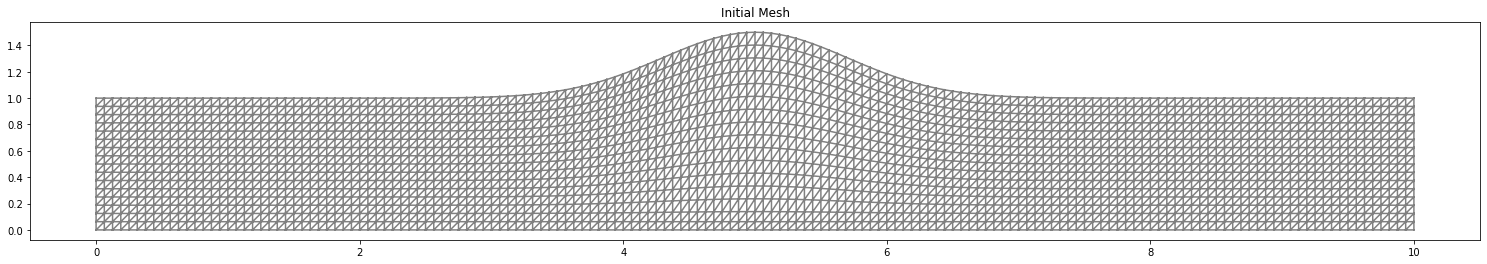

In [139]:
# Define rectangular domain 
L = 10
H = 1

# Define bump
B0 = H/10
r = L/6
bottom_shape = Expression("B0*pow(cos(pi*(x[0] - L/2)/(2*r)), 2.0)*(abs(x[0] - L/2) < r)", B0=B0, L=L, r=r, degree=2)
shape_displacement = Expression(("0", "(B0*pow(cos(pi*(x[0] - L/2)/(2*r)), 2.0)*(abs(x[0] - L/2) < r))*((H - x[1])/H)"), B0=B0, L=L, r=r, H=H, degree=2)

# Define initial wave shape (for debugging cases)
wave_epsilon = H/2
wave_width = L/10
wave_shape = Expression("H + weps*exp(-pow(x[0] - L/2, 2)/(ww*ww))", H=H, weps=wave_epsilon, L=L, ww=wave_width, degree=2)
# slightly hacky displacement to leave bottom untouched
effective_height = H - B0
wave_shape_displacement = Expression(("0", "(weps*exp(-pow(x[0] - L/2, 2)/(ww*ww)))*(x[1] > (H - EH))*((x[1] - H + EH)/EH)"), H=H, weps=wave_epsilon, L=L, ww=wave_width, EH=effective_height, degree=2)

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0)
        #return near(x[1], bottom_shape(x))

# todo: change depending on initial wave shape
class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], wave_shape(x))
      
left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh
resolution = 16
mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

#ALE.move(mesh, shape_displacement)
# displace for initial wave shape
ALE.move(mesh, wave_shape_displacement)

plt.figure(figsize=(40, 4))
plot(mesh, title="Initial Mesh")
plt.show()

**Define finite element approximation spaces**

In [140]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions 
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

In [141]:
# Define boundary conditions 
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        # the domain definition seems to be working
        return on_boundary and near(x[1], 0)
        #return on_boundary and near(x[1], bottom_shape(x))

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0))

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0) 

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
#uin = 1.0
#bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
#bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
#bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
#bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
#bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
#bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
#bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
#bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

#pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
#pout = 0.0
#bcp0 = DirichletBC(Q, pin, dbc_left) 
#bcp1 = DirichletBC(Q, pout, dbc_right)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
#bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
#bcp = [bcp1]

# Define measure for boundary integration  
#ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# TESTING conditions
bcu_left0 = DirichletBC(V.sub(0), 0.0, dbc_left)
#bcu_left1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_right0 = DirichletBC(V.sub(0), 0.0, dbc_right)
#bcu_right1 = DirichletBC(V.sub(1), 0.0, dbc_right)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)

bcp0 = DirichletBC(Q, 0.0, dbc_upper)

#bcu = [bcu_left0, bcu_left1, bcu_right0, bcu_right1, bcu_low0, bcu_low1]
bcu = [bcu_left0, bcu_right0, bcu_low0, bcu_low1]
bcp = [bcp0]


# **Results**

**Define flow parameters**

In [142]:
# Set viscosity
nu = 4.0e-1

# set gravity
g = 9.81
f = Expression(("0", "-g"), g=g, degree=2);

**Initial Conditions**

In [143]:
class InitialPressureExpression(UserExpression):
  def eval(self, value, x):
    value[0] = (wave_shape(x) - x[1])*g

  def value_shape(self):
    return ()

p_init = InitialPressureExpression()

**Define method parameters**

In [144]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step  
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# initial conditions


# Define mesh deformation w, mesh velocity = w/dt
#amp_x = 0.0
#amp_y = 1.0e-2
#freq = 0.1
#t = 0.0
#w = Expression(("amp_x*sin(2.0*pi*t*freq)*sin(pi*x[0]/L)","amp_y*sin(2.0*pi*t*freq-0.5*pi)*sin(pi*x[1]/H)"), L=L, H=H, t=t, amp_x=amp_x, amp_y=amp_y, freq=freq, element = V.ufl_element())

class DisplacementExpression(UserExpression):
    def set_md(self, displacement):
        if displacement == None:
            self.mesh_displacement = None
        else:
            self.mesh_displacement = interpolate(displacement, V)
            #self.mesh_displacement.set_allow_extrapolation(True)
    
    def eval(self, value, x):
        if self.mesh_displacement is None:
            value[0] = 0.0
            value[1] = 0.0
        else:
            result = self.mesh_displacement(x[0], x[1])
            value[0] = result[0]
            value[1] = result[1]

    def value_shape(self):
        return (2,)
w = DisplacementExpression()
w.set_md(None)

# Set parameters for nonlinear and lienar solvers 
num_nnlin_iter = 5 
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default" 

# Time step length 
dt = 0.5*mesh.hmin() *0.5 # TODO REMOVE DEBUG

**Define variational problem**

In [145]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*(um1-w/dt), v)*dx \
    - p1*div(v)*dx \
    + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*(um1-w/dt) + grad(p1), grad(v)*(um1-w/dt))*dx \
    + d2*div(um)*div(v)*dx \
    - inner(f, v)*dx
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*(um1-w/dt) + grad(p), grad(q))*dx + div(um1)*q*dx 
ap = lhs(Fp)
Lp = rhs(Fp)

**Set plotting variables and open export files**

In [146]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 20

# Time data 
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

In [ ]:
!rm results-NS/*

# apply initial conditions
p0.interpolate(p_init)
p1.interpolate(p_init)
# ^ does this even do anything?

print("Initial Pressure")
plt.figure(figsize=(40, 4))
plot(p1, title="Pressure")
print("===========")

# Time stepping
T = 30
t = dt

while t < T + DOLFIN_EPS:
    # extract the boundary mesh for the surface
    boundary = BoundaryMesh(mesh, "exterior", True)

    # extract the current surface height h(x)
    surface_nodes = []
    surface_node_indices = []
    left_max = 0
    left_max_index = -1
    right_max = 0
    right_max_index = -1
    for i, x in enumerate(boundary.coordinates()):
        if lower.inside(x, True):
            pass
            #print("Lower", x)
        elif left.inside(x, True):
            if x[1] > left_max:
                left_max = x[1]
                left_max_index = i
            #print("Left", x)
        elif right.inside(x, True):
            if x[1] > right_max:
                right_max = x[1]
                right_max_index = i
            #print("Right", x)
        else:
            #print("Top", x)
            surface_node_indices.append(i)
            surface_nodes.append(x)
    surface_node_indices.insert(0, left_max_index)
    surface_nodes.insert(0, boundary.coordinates()[left_max_index])
    surface_node_indices.append(right_max_index)
    surface_nodes.append(boundary.coordinates()[right_max_index])
    heights = [c[1] for c in surface_nodes]
    height_positions = [c[0] for c in surface_nodes]

    # extract the current surface velocity W(x)
    W = [u1(c[0], c[1]) for c in surface_nodes]

    # displace the boundary
    maxdisp = 0  # TODO: Remove debug statement
    for j, i in enumerate(surface_node_indices):
        x = boundary.coordinates()[i]
        delta_y = W[j][1]*dt
        x[1] += delta_y

        if delta_y > maxdisp:    # TODO: Remove debug statement
            maxdisp = delta_y    # TODO: Remove debug statement
    print("Maxdisp: ", maxdisp)  # TODO: Remove debug statement

    # Solve non-linear problem 
    k = 0
    while k < num_nnlin_iter: 
        
        # Assemble momentum matrix and vector 
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution 
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap) 
        bp = assemble(Lp)

        # Compute pressure solution 
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Add time
        if (t > start_sample_time):
          time = np.append(time, t)

        k += 1


    #boundary2 = BoundaryMesh(mesh, "exterior", True)
    #for i, x in enumerate(boundary.coordinates()):
    #    print(str(i) + ": ", x, " -> ", u1(x))

    if True or t > plot_time:     
        
        s = 'Time t = ' + repr(t) 
        print(s)
    
        # Save solution to file
        file_u << u1
        file_p << p1

        # Plot solution
        plt.figure(figsize=(40, 4))
        plot(u1, title="Velocity")

        plt.figure(figsize=(40, 4))
        plot(p1, title="Pressure")

        for w_temp in W:
          print(str(w_temp[1]) + " ", end="")
        print()
        
        plot_time += T/plot_freq
        
        plt.show()

    # reshape mesh
    w_new = ALE.move(mesh, boundary)
    w.set_md(w_new)
    # this supposedly helps to avoid crashing at solve
    mesh.bounding_box_tree().build(mesh)

    # show reshaped mesh
    print("New Mesh:")
    plt.figure(figsize=(40, 4))
    plot(mesh, title="Mesh")

    # Update time step
    u0.assign(u1)
    t += dt

#!tar -czvf results-NS.tar.gz results-NS
#files.download('results-NS.tar.gz')